establish a ratio cut off
find ways to analyse higher vmags


# What this code does
The code bellow imports all the data provided by TSM into two arrays one containing all the data of the stars frequency power specturm the other conatining the vmag andvmax of each star. The vmag will be used in calculation as it can be caulculated by Plato. The vmax will only be used to compare our final results to the the true value to evaluate if our code is working.

This code can calculated the vamx of a given number of stars if the stars vmag is also provided. We data raw data from the TSM team which does not have noise added to it. The process the data undergoes is as follows. Random noise is added to simulate realistic data, The data is then binned to remove the small rapid changes of the noise but preserve the larger overall shape. A curve is then fit to the background of the data. This background is then subtracted from the data overall to produce a roughly flat line. A gaussian is then fitted over the flattened data, this gaussian should fit to the envelope of p modes produced by the star. This whole process is repeated a given number of times (currently set to 100) the noise is added seperatly each time this is done to reduce the effect of the random noise. The vamx calculated for every trail and all the results are averaged to find the average vamx for that given star. This average vmax is also compared to the true vmax given by the TSM team.

The code returns a set of subplots for each of the stars, the subplots area as follows:

1. The raw data from the TSM team
1. The data with noise added to it
1. The data after being binned and a background fit shown
1. The data flattened after having the background fit subtracted from it
1. The data with a gaussian fitted around the envelope
1. A cropped version of the graph in subplot 5, cropped around the true value of vamx

The code then plots a graph showing how the distance between the true vamx and the calculated vmax changes with the vmag of the star. A line of bets fit is then calculated for this plot and is shown on the graph, The equation of this line is shown bellow.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
import math
from statistics import stdev 
from scipy import optimize
from scipy.integrate import simps
from scipy.integrate import quad

## Bin_it
This function bins one array and reduces another array to match its length so they can be plotted together. This is done to reduce the noise whihc comes from the noise on the data.
###  Inputs
- yvalues: y array, the Power normally called Fulldata in this code
- xvalues: x array, the frequency
- binsize: the size of the bin the y values will be averaged in, every binsizeth value will also be taken from the x array<br>
### Outputs
- Binned y array (Power)
- reduced x array (Frequency)

In [4]:
def bin_it(yvalues, xvalues, binsize):
    '''puts an array into averaged bins of a given size'''
    N=int(math.ceil(len(yvalues)/binsize))
    C=0
    newy=[]
    while C<N:
        if (C+1)*binsize<len(yvalues):
            Q=(np.sum(yvalues[C*binsize:(C+1)*binsize]))/binsize
        else:
            Q=(np.sum(yvalues[C*binsize:len(yvalues)]))/binsize
        newy.append(Q)
        C+=1
    y=np.array(newy)
    x=xvalues[0::binsize] 
    return y[0:len(y)-1], x[0:len(y)-1]

## addnoise
adds noise to and array. The method used to generate the noise was taken from a recommended scientific paper
### Input
- pure: orignal array
### output
- array with noise added

In [5]:
#Adds random noise
def addnoise(pure):
    vary = np.random.uniform(0, 1, pure.shape)
    signal = -(pure* np.log(vary))
    return signal

## gaus
The equation of a gaussian. 
### Inputs
- x: array over which the gaussian with background should be plotted
- height: Height of the gaussian
- centre: Centre of the gaussian
- width: Width of the gaussain at half its height
### Output
- An equation with gives a gaussian

In [6]:
def gaus(x, height, centre, width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))

## findgran
Finds an equation which describes the background noise of the initial data and returns the values needed to plot the background
### Inputs
- x: x value array (frequency) 
- y: y value arrat (power)
### Output
- best_vals is an array of to integers which can be put into graneq to fit the background noise

In [7]:
def findgran(x, y):
    #guess_vals=[np.max(y),y[round(len(y)/4)]]
    guess_vals=[0, 0]
    best_vals, covar =curve_fit(graneq, x, y, p0=guess_vals)
    return best_vals

## graneq
plots returns the y values of the background if the x array and two constants are inserted
### Inputs
- x: x array (frequency)
- A: constant calulated by findgran
- tau: constant calulated by findgran
### Output
- array of y values of the background

In [8]:
def graneq(x,A,tau,SN):
    '''equation to describe the background'''
    return A/(1+(2*np.pi*x*tau)**2)+SN

## find_nearest
finds the value in an array closest to a given number and returns the values index in the array
### Inputs
- array: array containing the values you want to test
- value: value which you want to find the nearest value of in the array
### Output
- index of the value in the array which is closest to the given number

In [9]:
def find_nearest(array, value):
    '''finds value closest to a given value in an array'''
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

Bellow are the equations for a straight line and an exponential line. Will be used for fitting a line of best fit for the final results

In [10]:
def f(x,a,b):
    return a*x+b
def f1(x,a,b,c):
    return a*np.exp(b*x)+c

Imports data

In [11]:
#data = np.genfromtxt('Kypoints.txt', delimiter=' ')
#extradata = np.genfromtxt('Kotherstuff.txt', delimiter=' ')
data = np.genfromtxt('Kypoints (1).txt', delimiter=' ')
extradata = np.genfromtxt('Kotherstuff (1).txt', delimiter=' ') 
extradata = np.delete(extradata, (0), axis=0) #removes title row

In [ ]:
def integrand1(x, a, b, c):
    I = a/(1+(2*np.pi*x*b)**4)+c
    return I

def integrand2(x,amplitude,centre,width):
    I = (amplitude**2)*(np.exp(-0.5*((x-centre)/width)**2))
    return I

## vmaxplot
Finds the vmax of a given number of stars. Returns a subplot showing the steps taken by the code.
### Inputs
- powerdata: The y values of a given star
- truevmax: The true vmax of a given star provided by TSM
- truevmag: The true vmag of a given star provided by TSM
- N: The number of trials for each star
- binsize: The bin size used in the binning step of the code
- Starnumber: The number of the star being tested used for the titles of graphs
- Want_subplot: If the code should return the subplots 'yes' subplots are wanted anything else will not return subplots
### Output
- difference: Returns the differnce between the truevmax and the fitted vmax for a given star

In [92]:
def vmaxplot(powerdata,truevmax,truevmag,N,binsize,Starnumber,Want_subplot):
    frequency=data[0]
    C=0
    fails=0
    amps=[]
    centres=[]
    Int1s=[]
    Int2s=[]
    widths=[] #generated empty arrays to store the information of the envelope gaussian fits
    while C<N: #loops while the counting variable is less than a given number N
        y,x=bin_it(addnoise(powerdata),frequency,binsize) #adds noise and bins
        SN = 18*10**(-0.4*(11.0-truevmag)) #Calculates Shot noise
        bv,covar =curve_fit(graneq,x,y,p0=[0,0,SN],bounds=([0,0,SN-SN/100],[np.inf,np.inf,SN+SN/100])) 
        Int1s.append(quad(integrand1, frequency[0], frequency[-1], args=(bv[0],bv[1],bv[2]))[0])
        #finds equation for background. SN is inculded as a variable so it can different for every star. The bounds on SN 
        #are very narrow though so the curve fitting program can not change it too much.
        background=graneq(x,bv[0],bv[1],bv[2]) #calculates the background of the data
        yflat=y-background #subtracts the background from the data
        p0=[0.05,6000,350] #initial guesses for gaussian
        try: #try and except are used incase the code can not fit a gaussian. try and expect stop the code from crashing
            best_vals, covar = curve_fit(gaus,x,yflat,p0=p0,bounds=([0.0,3000,0.0],[np.inf,14000,np.inf])) 
            #fits gaussian bounds are included as we know the centre of the peak must be in the data and the amp is not negative
            amps.append(best_vals[0])
            centres.append(best_vals[1])
            widths.append(best_vals[2]) # 
            Int2s.append(quad(integrand2, frequency[0], frequency[-1], args=(best_vals[0],best_vals[1],best_vals[2]))[0])
            C+=1
        except: #try and except are used incase the code can not fit a gaussian. try and expect stop the code from crashing
            fails+=1 #records a failure to fit a gaussain to the data
            C+=1
    if len(centres)>0: #included to prevent error is no peaks were detected
        average_v_max=np.mean(centres)
        difference=np.abs(average_v_max-truevmax)
        if Want_subplot=='yes': #controls if subplots are printed
            print(f'{fails}/{N} trails failed')
            print(f'average v_max {average_v_max} which is {difference} away from the true value of {truevmax}')
            ratio=np.mean(Int2s)/np.mean(Int1s)
            print(f'ratio={ratio}')
            print(f'times worse than base line {0.00011375652938425257/ratio}')
            #Code bellow plots sub plots tracking process of the analysis
            fig, axs  = plt.subplots(3, 2,figsize=(12,12))
            fig.suptitle(f'Star {int(Starnumber)} vmag: {truevmag}', fontsize=20)
            axs[0,0].plot(frequency, powerdata, label='data')
            axs[0,0].set_title('Data provided by TSM')
            axs[0,0].set_xlabel('Frequency')
            axs[0,0].set_ylabel('Power')
            axs[0,0].legend()
            axs[0,1].plot(frequency, addnoise(powerdata), label='data')
            axs[0,1].set_title('Noise added')
            axs[0,1].set_xlabel('Frequency')
            axs[0,1].set_ylabel('Power')
            axs[0,1].legend()
            axs[1,0].plot(x, y, label='data')
            axs[1,0].plot(x, background, label='Fitted background')
            axs[1,0].axvline(truevmax, color='yellow', label='True vmax')
            axs[1,0].set_title(f'Binned binsize: {binsize} background fitted')
            axs[1,0].set_xlabel('Frequency')
            axs[1,0].set_ylabel('Power')
            axs[1,0].legend()
            axs[1,1].plot(x, yflat, label='data')
            axs[1,1].axhline(0, color='black')
            axs[1,1].set_title('Background subtracted from data')
            axs[1,1].set_xlabel('Frequency')
            axs[1,1].set_ylabel('Power')
            axs[1,1].legend()
            axs[2,0].plot(x, yflat, label='data')
            axs[2,0].plot(x, gaus(x, np.mean(amps), np.mean(centres), np.mean(widths)), label='Fitted gaussian')
            axs[2,0].axvline(truevmax,color='yellow', label='True vmax')
            axs[2,0].axvline(average_v_max, color='purple', label='Fitted vmax')
            axs[2,0].set_title('Fitted gaussian')
            axs[2,0].set_xlabel('Frequency')
            axs[2,0].set_ylabel('Power')
            axs[2,0].legend()
            bottom=find_nearest(x, truevmax-2500)
            top=find_nearest(x, truevmax+2500)
            xf=x[bottom:top]
            yflatf=yflat[bottom:top]#crops data down
            axs[2,1].plot(xf, yflatf,label='data')
            axs[2,1].plot(xf, gaus(xf, np.mean(amps), np.mean(centres), np.mean(widths)), label='Fitted gaussian')
            axs[2,1].axvline(truevmax, color='yellow', label='True vmax')
            axs[2,1].axvline(average_v_max, color='purple', label='Fitted vmax')
            axs[2,1].set_title('Cropped fitted gaussian')
            axs[2,1].set_xlabel('Frequency')
            axs[2,1].set_ylabel('Power')
            axs[2,1].legend()
            plt.subplots_adjust(top=0.95, hspace=0.3)
            plt.show()
            print('-----------------------------------------------------------------------------------------------------------')
        return centres,widths,Starnumber
    else:
        print('fails')
        plt.plot(x, y, label='data')
        plt.plot(x, background, label='background')
        plt.legend()
        plt.show()

How many stars do you want to analyse? pick an integer no larger than 50: 10
Do you want subplots? (yes or no): yes
0/10 trails failed
average v_max 4954.988966598956 which is 111.45538930634666 away from the true value of 4843.533577292609
ratio=0.00011375652938425257
times worse than base line 1.0


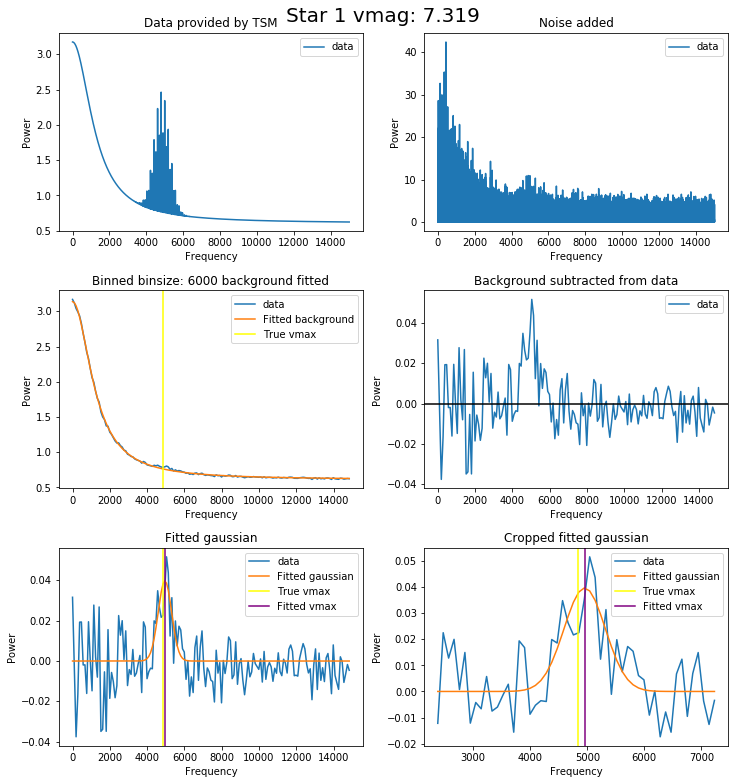

-----------------------------------------------------------------------------------------------------------
0/10 trails failed
average v_max 6192.2500756670515 which is 213.47363132092687 away from the true value of 5978.776444346125
ratio=2.1086612838369483e-05


UnboundLocalError: local variable 'baseline' referenced before assignment

In [93]:
#inputs let user decided what is returned
Number_of_star=input(f'How many stars do you want to analyse? pick an integer no larger than {len(extradata[:,0])}: ')
Want_subplot=input('Do you want subplots? (yes or no): ')
centresarray=[]
widthsarray=[]
StarNosarray=[]
m=np.linspace(1,int(Number_of_star),int(Number_of_star)) #containing integers from 1 to the chosen number of stars
binsize=6000
number_of_trails=10
for n in m:
    centres,widths,Starnumbers=vmaxplot(data[int(n)], extradata[int(n)-1,1], extradata[int(n)-1,2], number_of_trails,binsize,n,Want_subplot)
    centresarray.append(centres)
    widthsarray.append(widths)
    StarNosarray.append(Starnumbers)
    if n % 10 == 0: #if statment prints progress of the code will it is running
        print(f'{int(n)}/{int(Number_of_star)} stars run')
centresarray=np.array(centresarray)
averagecentres=np.mean(centresarray, axis = 1)
vmaxs=extradata[:,1]
vmaxs=vmaxs[0:int(Number_of_star)]
differences=np.abs(averagecentres-vmaxs)
variences=np.var(centresarray, axis = 1)
if len(differences)>0:
    vmags=extradata[:,2]
    vmags=vmags[0:int(Number_of_star)]
    plt.plot(vmags,differences, label='data')
    try:
        bvs1, covar = curve_fit(f1,vmags,differences,p0=[1,1,150])
    except:
        bvs1, covar = curve_fit(f,vmags,differences,p0=[1,150])
    if len(bvs1)>2:
        plt.plot(vmags,f1(vmags,bvs1[0],bvs1[1],bvs1[2]),label='Line of best fit')
    else:
        plt.plot(vmags,f(vmags,bvs1[0],bvs1[1]),label='Line of best fit')
    plt.xlabel('vmag')
    plt.ylabel('Difference between true and fitted vmax')
    plt.title('Difference between true and fitted vmax for each vmag')
    plt.legend()
    plt.show()
    if len(bvs1)>2:
        print(f'Equation of line of best fit for vmag against difference: {bvs1[0]}*e^({bvs1[1]}*x){bvs1[2]}')
    else:
        print(f'Equation of line of best fit for vmag against difference: {bvs1[0]}*x{bvs1[1]}')
if len(variences)>0:
    plt.plot(vmags,variences, label='data')
    plt.axhline(0, color='black', linestyle='--')
    try:
        bvs1, covar = curve_fit(f1,vmags,variences,p0=[0,0,0])
    except:
        bvs1, covar = curve_fit(f,vmags,variences,p0=[0,0])
    if len(bvs1)>2:
        plt.plot(vmags,f1(vmags,bvs1[0],bvs1[1],bvs1[2]),label='Line of best fit')
    else:
        plt.plot(vmags,f(vmags,bvs1[0],bvs1[1]),label='Line of best fit')
    plt.xlabel('vmag')
    plt.ylabel('Varience of vmax values')
    plt.title('Varience of vmax values against vmag')
    plt.legend()
    plt.show()
    if len(bvs1)>2:
        print(f'Equation of line of best fit for vmag against varience: {bvs1[0]}*e^({bvs1[1]}*x){bvs1[2]}')
    else:
        print(f'Equation of line of best fit for vmag against varience: {bvs1[0]}*x{bvs1[1]}')

In [61]:
def largesep(rawdata, vmax, width,Starnumber):
    frequency=data[0]
    binsize=10
    '''
    calculates the large separation between the most prominant l modes
    rawdata: imported data 
    vmax: calculated vmax of the Gaussian envelope
    width: calculated width of the Gaussian envelope
    -------------------------------
    returns array of [int(P), mean_no_peaks, mean_no_peaks_std, mean_lspacing, mean_lspacing_std] 
    int(P): Star Index
    mean_no_peaks, mean_no_peaks_std: mean number of peaks identified and standard deviation on this
    mean_lspacing, mean_lspacing_std: mean large spacing and the standard deviation on this
    '''
    p_centre = 5000
    halfwidth = width/2  #to be replaced with the calculated width
    D = 0
    Dmax = 25
    
    xny=bin_it(addnoise(rawdata),frequency,binsize)
    xdata = xny[1]
    ydata = xny[0]
    
    
    if vmax == 0 or vmax<3000: #indexing to centre peak finding around the Gaussian envelope
        low = p_centre-halfwidth    #and if vmax<3000 it will default to vmax=p_centre=5000
        high = p_centre+halfwidth
        lowbound = np.where(xdata>3999)[0][0] #need to put in terms of vmax
        highbound = np.argwhere(xdata>5999)[0][0]
    else:
        low = vmax-4*halfwidth   #if vmax is good, it will centre the peak finding function on that vmax
        high = vmax+4*halfwidth
        lowbound = np.argwhere(xdata>(low))[0][0]
        highbound = np.argwhere(xdata>(high))[0][0]
    
    #generating low binned data
    binned_p, binned_x = bin_it(ydata[lowbound:highbound], xdata[lowbound:highbound],binsize) 
    best_thresh = []
    no_peaks = []
    
    #finding the best no. peaks to match to by looping over different noisy data sets 
    while D<Dmax:    #and finding the average number of peaks it detects
        xny=bin_it(addnoise(rawdata),frequency,binsize)
        binned_p, binned_x = bin_it(xny[0][lowbound:highbound], xny[1][lowbound:highbound],binsize)
        nos_peaks = len(indexes(binned_p, thres=0.375, min_dist=30))
        no_peaks = np.append(no_peaks, [nos_peaks])
        D=D+1
    mean_no_peaks = np.mean(no_peaks)
    mean_no_peaks_std = np.std(no_peaks)
    print(f' The mean number of peaks is {np.round(mean_no_peaks,decimals=0)} ± {np.round(mean_no_peaks_std,decimals=0)}') 
    #if mean number of peaks is too low or too high, something is wrong, roughly between 10-20 from testing
    
    #finding the best threshold value
    for i in np.linspace(0.25,0.5,70): 
        xny=bin_it(addnoise(rawdata),frequency,binsize)
        binned_p, binned_x = bin_it(xny[0][lowbound:highbound], xny[1][lowbound:highbound],binsize)
        indexess = indexes(binned_p, thres=i, min_dist=30)
        if len(indexess) == np.round((np.mean(no_peaks)),decimals=0): #selecting all thresholds that produce
            best_thresh = np.append(best_thresh,i)       #the same number of peaks as the average number 'no_peaks'
    print(f' The mean threshold is {np.round(np.mean(best_thresh),decimals=4)} ± {np.round(np.std(best_thresh),decimals=4)}')
    
    indexes2 = indexes(binned_p, thres=np.mean(best_thresh), min_dist=30) #finds peaks with best_thresh
    freq_array = np.array(binned_x[indexes2])
    pyplot(binned_x, binned_p, indexes2) #plots the peaks on a separate graph
    plt.show()
    
    n=0
    large_sep = []
    spacing = []
    
    #calculating the large separation
    for i in freq_array:
        nmax=len(freq_array)
        while n<nmax-1:
            z = abs(freq_array[n]-freq_array[n+1])
            if z<100:
                spacing = np.append(spacing, [z])
            n=n+1
            spacing = (np.array(spacing))
    mean_lspacing = 2*np.mean(spacing)
    mean_lspacing_std = np.std(spacing)
    print(f'The mean large spacing for Star {Starnumber} is {np.round(mean_lspacing,decimals=2)} ± {np.round(mean_lspacing_std,decimals=2)}')
    print('')
    return np.array([ int(Starnumber), mean_no_peaks, mean_no_peaks_std, mean_lspacing, mean_lspacing_std])

 The mean number of peaks is 12.0 ± 2.0
 The mean threshold is 0.3539 ± 0.0493


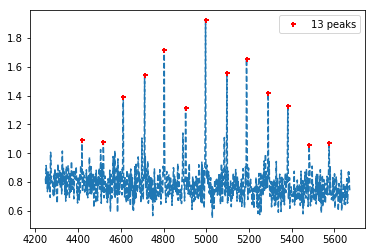

The mean large spacing for Star 1.0 is 191.98 ± 3.6

 The mean number of peaks is 23.0 ± 1.0
 The mean threshold is 0.3683 ± 0.0705


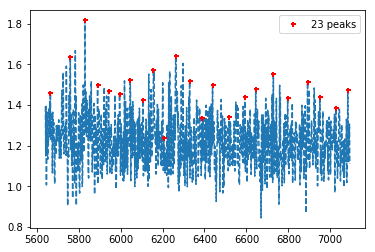

The mean large spacing for Star 2.0 is 128.99 ± 13.76

 The mean number of peaks is 21.0 ± 1.0
 The mean threshold is 0.3557 ± 0.0659


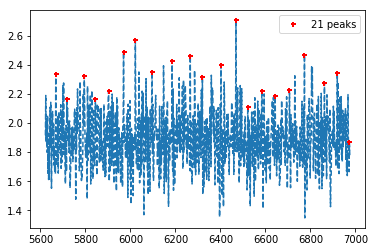

The mean large spacing for Star 3.0 is 130.48 ± 12.58

 The mean number of peaks is 19.0 ± 2.0
 The mean threshold is 0.3419 ± 0.0609


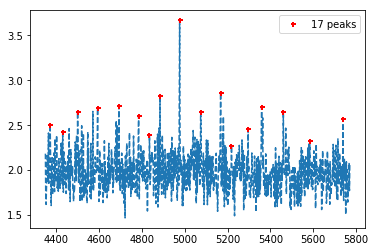

The mean large spacing for Star 4.0 is 152.2 ± 18.99



KeyboardInterrupt: 

In [62]:
a=np.mean(centresarray,axis=1)
b=np.mean(widthsarray,axis=1)
largesepdata=[]
for n in StarNosarray:
    largesepdata.append(largesep(data[int(n)],a[int(n)-1],b[int(n)-1],n))
    

In [17]:
def pyplot(x, y, ind):
    """
    Plots the original data with the peaks that were identified

    Parameters
    ----------
    x : array-like
        Data on the x-axis
    y : array-like
        Data on the y-axis
    ind : array-like
        Indexes of the identified peaks
    """
    plt.plot(x, y, "--")

    marker_x = x.iloc[ind] if hasattr(x, "iloc") else x[ind]
    marker_y = y.iloc[ind] if hasattr(y, "iloc") else y[ind]

    plt.plot(marker_x, marker_y, "r+", ms=5, mew=2, label="{} peaks".format(len(ind)))
    plt.legend()


In [75]:
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    """Peak detection routine.

    Finds the numeric index of the peaks in *y* by taking its first order difference. By using
    *thres* and *min_dist* parameters, it is possible to reduce the number of
    detected peaks. *y* must be signed.

    Parameters
    ----------
    y : ndarray (signed)
        1D amplitude data to search for peaks.
    thres : float between [0., 1.]
        Normalized threshold. Only the peaks with amplitude higher than the
        threshold will be detected.
    min_dist : int
        Minimum distance between each detected peak. The peak with the highest
        amplitude is preferred to satisfy this constraint.
    thres_abs: boolean
        If True, the thres value will be interpreted as an absolute value, instead of
        a normalized threshold.

    Returns
    -------
    ndarray
        Array containing the numeric indexes of the peaks that were detected.
        When using with Pandas DataFrames, iloc should be used to access the values at the returned positions.
    """
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks
